Guillaume Chaslot <guillaume.chaslot@data.gouv.fr>

# Tax Legislation Refactoring

The tax/benefit legislation on individuals in France is more than 200,000 lines long.

We believe that with this tool, you can make it less than 100 lines, transparent, and 95% similar to the existing legislation

### How it works:

1. Define your concepts (e.g., 'nb_enfants', 'age', 'parent isolé') and budget (e.g.: cost less than 2 millions euros)
2. The machine learning algorithm helps you adjust the parameters of your reform to approximate the current legislation and fit your budget
3. From the biggest discrepencies with the current legislation, you can improve your concepts (or the legislation)
4. Repeat until you reach a legislation that matches your own goals. The algorithm takes care of minimizing your budget and maximizing the similarity to current legislation.

### Beta version limitations:

For this test, we only take a population of people from all ages, who have 0 to 5 children, no salary, married, veuf, paces, divorces or celibataires, and simulate the "aides sociales"

### Current Results:

Within a few minutes, we got a tax reform for "aides sociales" for people with no salary that is:

* 6 lines long 
* similar to the existing in average at more than 95%


In [1]:
from utils import show_histogram, percent_diff, scatter_plot, multi_scatter

import matplotlib.pyplot as plt
# import bqplot.pyplot as plt

import pandas as pd
import numpy as np
import random
import qgrid
import copy

from reformators import Excalibur

qgrid.nbinstall(overwrite=True)

%matplotlib inline

def show_last_reform_results():
    if cost > 0:
        display_cost_name = 'Total Cost in Euros'
        display_cost_value = int(cost)
    else:
        display_cost_name = 'Total Savings in Euros'
        display_cost_value = -int(cost)

    result_frame = pd.DataFrame({
        display_cost_name: [display_cost_value],
        'Average change / family / month in Euros' : [int(error) / 12],
        })

    result_frame.set_index(display_cost_name, inplace=True)
    qgrid.show_grid(result_frame)


# Which variable do you want to optimize?

Here, we want to optimize the variable 'revdisp' which by putting a tax on 'taxable_income'

In [2]:
reformator = Excalibur(target_variable='revdisp',
                       taxable_variable='taxable_variable')

# What is the population you want to use?

The population data is simulated for now, see population_simulator.py for details.

In [3]:
reformator.load_openfisca_results('1aj-1bj-f-2000')

# Removing unlikely cases of super old parents due to our approximative population
# reformator.filter_only_likely_population()

# # Keeping only people with no revenu for this test
# reformator.filter_only_no_revenu()

# What are the concept you want to use for your reform?

You can add concepts like the number of children, age, family situation, etc... 

The input population is in the CERFA "declaration des revenus" format.

In [4]:

def age_dec_1(family):
    return age_from_box(family, '0DA')

def age_dec_2(family):
    if '0DB' in family:
        return age_from_box(family, '0DB')
    return None

def if_married(family):
    return 'M' in family

def if_pacse(family):
    return 'O' in family

def if_veuf(family):
    return 'V' in family

def if_divorce(family):
    return 'D' in family

def if_two_people(family):
    return '0DB' in family

def revenu_1(family):
    return family['1AJ']

def taxable_variable(family):
    if '1BJ' in family:
        return family['1AJ'] + family['1BJ']
    else:
        return family['1AJ']

def revenu_2(family):
    if '1BJ' in family:
        return family['1BJ']
    return False
    
def age_from_box(family, birthdate_box):
    return 2014 - family.get(birthdate_box, 2014)

def if_both_declarant_parent_below_24(family):
    if age_dec_1(family) >= 24:
        return False
    if '0DB' in family and age_dec_2(family) >= 24:
        return False
    if 'F' not in family or family['F'] == 0:
        return False
    return True

def per_child(family):
    if 'F' in family:
        return family['F']
    else:
        return None

def per_child_parent_isole(family):
    if '0DB' in family:
        return None
    if 'F' in family:
        return family['F']
    else:
        return None

def if_parent_isole(family):
    return 'F' in family and family['F'] >= 1 and ('0DB' not in family)

def if_enfant_unique(family):
    return 'F' in family and family['F'] == 1

def if_deux_enfants_ou_plus(family):
    return 'F' in family and family['F'] >= 2

def nb_enfants_after_2(family):
    if 'F' in family and family['F'] >= 2:
        return family['F'] - 2
    return None

def if_declarant_above_65(family):
    return age_from_box(family, '0DA') >= 65
    
def if_codeclarant_above_65(family):
    return '0DB' in family and age_from_box(family, '0DB') > 65

def per_declarant_above_65(family):
    return int(age_from_box(family, '0DB') >= 65) + int(age_from_box(family, '0DA') >= 65)

def per_declarant_above_24(family):
    return int(age_from_box(family, '0DB') >= 24) + int(age_from_box(family, '0DA') >= 24)

def if_one_declarant_above_24(family):
    return (age_from_box(family, '0DA') >= 24 or ('0DB' in family and age_from_box(family, '0DB') >= 24))

def if_one_declarant_above_24_or_has_children(family):
    return (age_from_box(family, '0DA') >= 24 or ('0DB' in family and age_from_box(family, '0DB') >= 24) or 
           ('F' in family and family['F'] >= 1))

def if_earns_10k(family):
    return taxable_variable(family) > 10000

def base(family):
    return True

reformator.add_concept('base', base)
reformator.add_concept('age_dec_1', age_dec_1)
reformator.add_concept('age_dec_2', age_dec_2)
reformator.add_concept('taxable_variable', taxable_variable)
reformator.add_concept('revenu_1', revenu_1)
reformator.add_concept('revenu_2', revenu_2)
reformator.add_concept('per_child', per_child)
reformator.add_concept('per_child_parent_isole', per_child_parent_isole)
reformator.add_concept('per_declarant_above_24', per_declarant_above_24)
reformator.add_concept('per_declarant_above_65', per_declarant_above_65)
reformator.add_concept('nb_enfants_after_2', nb_enfants_after_2)
reformator.add_concept('if_earns_10k', if_earns_10k)
reformator.add_concept('if_one_declarant_above_24', if_one_declarant_above_24)
reformator.add_concept('if_one_declarant_above_24_or_has_children', if_one_declarant_above_24_or_has_children)
reformator.add_concept('if_both_declarant_parent_below_24', if_both_declarant_parent_below_24)
reformator.add_concept('if_declarant_above_65', if_declarant_above_65)
reformator.add_concept('if_codeclarant_above_65', if_codeclarant_above_65)
reformator.add_concept('if_enfant_unique', if_enfant_unique)
reformator.add_concept('if_deux_enfants_ou_plus', if_deux_enfants_ou_plus)
reformator.add_concept('if_two_people', if_two_people)
reformator.add_concept('if_parent_isole', if_parent_isole)
reformator.add_concept('if_parent_isole_moins_20k', if_parent_isole)

reformator.summarize_population()

Echantillon of 2863 people, in percent of french population for similar revenu: 0.14315%


# Plots Revenu disponible before reform

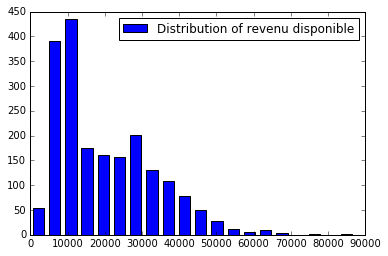

In [5]:
revdisp = list(family['revdisp'] for family in reformator._population)

show_histogram(revdisp, 'Distribution of revenu disponible')

# <font color='red'>Define your reform here!</font>


In [33]:
simulated_reform, error, cost, final_parameters  = reformator.suggest_reform(
            parameters=[
                            'per_child',
                            'if_one_declarant_above_24_or_has_children',
                            'if_two_people',
                            'if_parent_isole',
                            'if_declarant_above_65',
                            'if_codeclarant_above_65'
                        ],
            tax_rate_parameters=[
                'base',
                'if_enfant_unique',
                'if_deux_enfants_ou_plus',
            ],
            tax_threshold_parameters=[
                'base',
                'if_enfant_unique',
                'if_deux_enfants_ou_plus',
            ],
            max_cost=0,
            min_saving=0)

['per_child', 'if_one_declarant_above_24_or_has_children', 'if_two_people', 'if_parent_isole', 'if_declarant_above_65', 'if_codeclarant_above_65']
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=981504, Fri Oct  7 18:11:38 2016)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.217197625180871e+05 1.0e+00 9.55e+03  9e+03  1e+04 0:0.1
Best solution: average change / person / month = 1060 costing a total of -12027 millions per year
    2     20 3.986139630212295e+05 1.2e+00 9.24e+03  9e+03  1e+04 0:0.2
    3     30 2.773872394032241e+05 1.3e+00 8.72e+03  8e+03  9e+03 0:0.3
Best solution: average change / person / month = 210 costing a total of -429 millions per year
Best solution: average change / person / month = 220 costing a total of -1565 millions per year
Best solution: average change / person / month = 1030 costing a total of 770 millions per year
Best solution: average change / person / month = 198 costing a total of -600 millions per 

In [34]:
show_last_reform_results()

In [35]:
print repr(final_parameters)
def show_coefficients(final_parameters, current_type,):
    coefficients = []
    variables = []
    for parameter in final_parameters:
        if parameter['type'] == current_type:
            coefficients.append(parameter['value']);
            variables.append(parameter['variable'])

    result_frame = pd.DataFrame({'Variables': variables, current_type + ' coef': coefficients})
    result_frame.set_index('Variables', inplace=True)
    qgrid.show_grid(result_frame)

show_coefficients(final_parameters, 'base_revenu')
show_coefficients(final_parameters, 'tax_rate')
show_coefficients(final_parameters, 'tax_threshold')

[{'variable': 'if_one_declarant_above_24_or_has_children', 'type': 'base_revenu', 'value': 2219.282343853265}, {'variable': 'per_child', 'type': 'base_revenu', 'value': 2041.9004333093762}, {'variable': 'if_two_people', 'type': 'base_revenu', 'value': 984.25462064146996}, {'variable': 'if_declarant_above_65', 'type': 'base_revenu', 'value': 5790.5383074730635}, {'variable': 'if_codeclarant_above_65', 'type': 'base_revenu', 'value': 4811.6771410927176}, {'variable': 'if_parent_isole', 'type': 'base_revenu', 'value': 924.0449829766294}, {'variable': 'baseif_enfant_uniqueif_deux_enfants_ou_plus', 'type': 'tax_rate', 'value': 7993.0361308008432}, {'variable': 'baseif_enfant_uniqueif_deux_enfants_ou_plus', 'type': 'tax_threshold', 'value': 5568.9143402799964}]


In [29]:
new_pop = copy.deepcopy(reformator._population)

for i in range(len(new_pop)):
    new_pop[i]['reform'] = simulated_reform[i] 

def plot_for_population(pop):
    revenu_imposable = list(family['taxable_variable'] for family in pop)
    revdisp = list(family['revdisp'] for family in pop)
    reform = list(family['reform'] for family in pop)

    multi_scatter('Revenu disponible for different people before / after reforme', 'Revenu initial', 'Revenu disponible', [
                  {'x':revenu_imposable, 'y':reform, 'label':'Reform', 'color':'blue'},
                  {'x':revenu_imposable, 'y':revdisp, 'label':'Original', 'color':'red'},
              ])

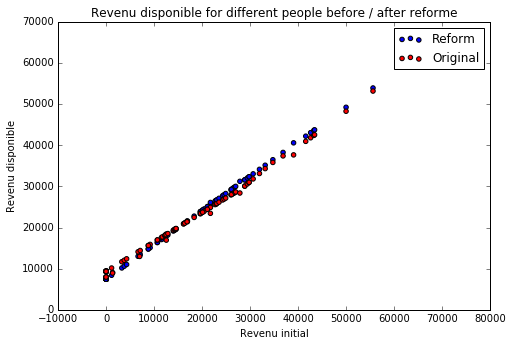

In [31]:
un_enfant_pop = list(filter(lambda x: x.get('per_child', 0) == 1
                                  and x.get('age_dec_1', 0) < 65
                                  and x.get('age_dec_2', 0) < 65,
                            new_pop))
plot_for_population(un_enfant_pop)



In [11]:
show_last_reform_results()

In [12]:
# simulated_reform_tree, error_tree, cost_tree, final_parameters_tree  = reformator.suggest_reform_tree(
#             parameters=[
#                             'per_child',
#                             'if_one_declarant_above_24_or_has_children',
#                             'age_dec_1',
#                             'age_dec_2'
#                         ],
#                             max_cost=0,
#                             min_saving=0,
#                             image_file='./enfants_age',
#                             max_depth=5,
#                             min_samples_leaf=20
#                         )

# <font color="darkgreen">Reform results</font>

In [13]:
# show_last_reform_results()
# from IPython.display import Image
# Image(filename='./enfants_age.png')

#  <font color="darkgreen">Reform parameters</font>

# Plots revenu disponible after reform

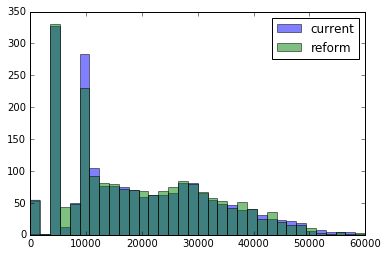

In [14]:
xmin = 0
xmax = 60000
nb_buckets = 35

bins = np.linspace(xmin, xmax, nb_buckets)

plt.hist(revdisp, bins, alpha=0.5, label='current')
plt.hist(simulated_reform, bins, alpha=0.5, label='reform')
plt.legend(loc='upper right')
plt.show()

# Distribution of the changes in revenu in euros

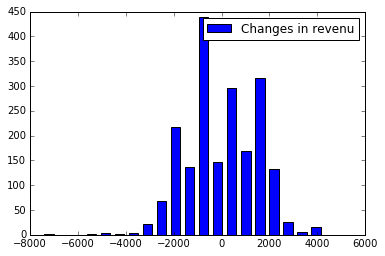

In [15]:
difference = list(simulated_reform[i] - revdisp[i] for i in range(len(simulated_reform)))

show_histogram(difference, 'Changes in revenu')

# Distribution of the change in revenu in percentage

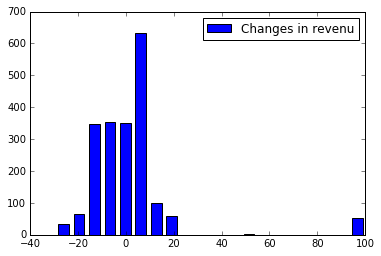

In [16]:
percentage_difference = list(100 * percent_diff(simulated_reform[i], revdisp[i]) for i in range(len(simulated_reform)))

show_histogram(percentage_difference, 'Changes in revenu')

# Change as a function of the number of children

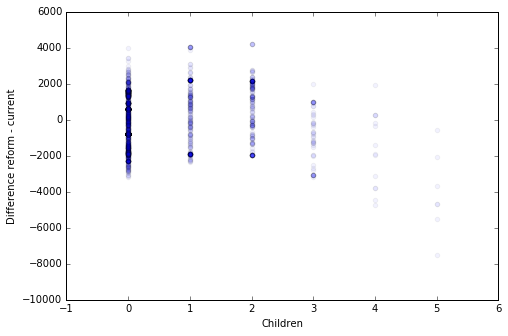

In [17]:
nb_children = list((reformator._population[i].get('per_child', 0)  for i in range(len(reformator._population)))) 

scatter_plot(nb_children, difference, 'Children', 'Difference reform - current', alpha=0.05)

# Change as a function of the age of declarant 1

A scatter plot is better than a thousand points #ChineseProverb

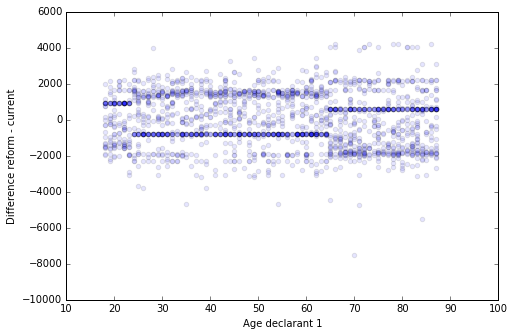

In [18]:
age_dec1 = list((reformator._population[i].get('age_dec_1', 0)  for i in range(len(reformator._population)))) 

scatter_plot(age_dec1, difference, 'Age declarant 1', 'Difference reform - current', alpha=0.1)

# <font color="Red">Most important: Edge Cases</font>

This is the heart of this tool: by seeing the worse cases, you can discover when the current legislation is smarter than yours (or the other way), and improve it further

In [19]:
order = sorted(range(len(simulated_reform)), key=lambda k: -abs(simulated_reform[k] - revdisp[k]))

data = {}

possible_keys = set()
for i in order:
    for key in reformator._raw_population[i]:
        if key != 'year':
            possible_keys.add(key)

for i in order:
    # Adding the diff with the reform.
    differences = data.get('difference', [])
    differences.append(abs(int(simulated_reform[i] - revdisp[i])))
    data['difference'] = differences

    for key in possible_keys:
        new_vals = data.get(key, [])
        value = reformator._raw_population[i].get(key, '')
        if type(value) == float:
            value = int(value)
        new_vals.append(value)
        data[key] = new_vals

    # Adding reformed line.
    reforms = data.get('reform', [])
    reforms.append(int(simulated_reform[i]))
    data['reform'] = reforms

df = pd.DataFrame(data=data)
df.set_index('difference', inplace=True)
qgrid.show_grid(df)


# Best compromise simplicity / matching current legislation:

In [20]:
res, error, cost, final_parameters = reformator.suggest_reform(parameters=[
                            'if_one_declarant_above_24',
                            'if_declarant_above_64',
                            'if_codeclarant_above_64',
                            'if_both_declarant_parent_below_24',
                            'if_two_people',
                            'if_enfant_unique',
                            'if_deux_enfants_ou_plus',
                            'nb_enfants_after_2',
                           ])

['if_one_declarant_above_24', 'if_declarant_above_64', 'if_codeclarant_above_64', 'if_both_declarant_parent_below_24', 'if_two_people', 'if_enfant_unique', 'if_deux_enfants_ou_plus', 'nb_enfants_after_2']
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=933768, Fri Oct  7 16:01:27 2016)
Best solution: average change / person / month = 1904 costing a total of -31740 millions per year
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.284995976249402e+05 1.0e+00 9.32e+03  9e+03  1e+04 0:0.1
    2     18 3.880225768012544e+05 1.2e+00 8.94e+03  8e+03  9e+03 0:0.2
    3     27 3.217744053729149e+05 1.3e+00 9.26e+03  8e+03  1e+04 0:0.2
Best solution: average change / person / month = 1588 costing a total of 512 millions per year
Best solution: average change / person / month = 319 costing a total of -864 millions per year
Best solution: average change / person / month = 1474 costing a total of 1283 millions per year
Best solution: average change / p

In [21]:
coefficients = list(map(lambda x: x['value'], final_parameters)); variables = list(map(lambda x: x['variable'], final_parameters))
result_frame = pd.DataFrame({'Variables': variables, 'Coefficient': coefficients})
result_frame.set_index('Variables', inplace=True)
qgrid.show_grid(result_frame)